# Project 1.1 Political Bias Detection in German News

In [ ]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import plotly.express as px
from plotly.offline import plot
import string
import random
from numpy.linalg import norm
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from gensim.models import Word2Vec
from imblearn.under_sampling import RandomUnderSampler
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.preprocessing import MinMaxScaler
from transformers import logging
logging.set_verbosity_warning()

In [ ]:
#!pip install datasets

In [ ]:
#!python3 -m spacy download de_core_news_md

In [ ]:
import spacy
nlp = spacy.load('de_core_news_md')

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning:

[W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu



In [ ]:
df=pd.read_csv(r"political_bias_dataset.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13855 entries, 0 to 13854
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  13855 non-null  int64 
 1   title       13855 non-null  object
 2   body        13855 non-null  object
 3   label       13855 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 433.1+ KB


In [ ]:
df.shape

(13855, 4)

In [ ]:
df.head()

,Unnamed: 0,title,body,label
0,0,Schulz: Gratisflüge mit EU-Jets für's Parteive...,Schulz: Gratisflüge mit EU-Jets für's Parteive...,1
1,1,Sachsen hat gewählt: Der Krimi um die leeren A...,Von: Sören Haberlandt und Michael Kruse\nIrrer...,1
2,2,SNP-Chefin greift Boris Johnson an - und forde...,SNP-Chefin greift Boris Johnson an - und forde...,0
3,3,Siemens-Chef Kaeser will nach Saudi-Arabien,Siemens-Chef Kaeser will nach Saudi-Arabien\nA...,1
4,4,"""Maybrit Illner"": Kanzleramtschef Altmaier ver...",Die von der SPD lange abgelehnte Große Koaliti...,1


In [ ]:
df.columns

Index(['Unnamed: 0', 'title', 'body', 'label'], dtype='object')

In [ ]:
df.drop("Unnamed: 0", axis=1, inplace=True)

In [ ]:
df.head(20)

,title,body,label
0,Schulz: Gratisflüge mit EU-Jets für's Parteive...,Schulz: Gratisflüge mit EU-Jets für's Parteive...,1
1,Sachsen hat gewählt: Der Krimi um die leeren A...,Von: Sören Haberlandt und Michael Kruse\nIrrer...,1
2,SNP-Chefin greift Boris Johnson an - und forde...,SNP-Chefin greift Boris Johnson an - und forde...,0
3,Siemens-Chef Kaeser will nach Saudi-Arabien,Siemens-Chef Kaeser will nach Saudi-Arabien\nA...,1
4,"""Maybrit Illner"": Kanzleramtschef Altmaier ver...",Die von der SPD lange abgelehnte Große Koaliti...,1
5,Das Abendland geht seinem Untergang entgegen,Der heilige Augustinus schrieb in seiner Predi...,2
6,Polizist sorgt mit Abzeichen für Wirbel,Bei Rechtsrockfestival: Polizist sorgt mit Abz...,0
7,Staatsanwaltschaft beschuldigt WDR wegen Fake-...,"Was Relotius beim Spiegel konnte, kann der WDR...",2
8,Wird er Kanzlerkandidat der Union? Diese Gründ...,Wird Markus Söder Kanzlerkandidat der Union? D...,0
9,Bernie Sanders unterstützt Joe Biden,Die US-Demokraten rücken im Kampf gegen Präsid...,0


In [ ]:
df.isnull().sum()   #no null values

title    0
body     0
label    0
dtype: int64

In [ ]:
df.duplicated().sum()   #43 duplicates in the dataset, need to be removed

43

In [ ]:
df[df.duplicated()]

,title,body,label
4312,Absage an SPD-Vorstoß: Parteienforscher Jürgen...,Von: Von Franz Solms-Laubach\nBundestagsvizepr...,1
4983,Deutsche EU-Ratspräsidentschaft - Nicht überfr...,"In Brüssel sagen viele, am Mittwoch werde offi...",0
5050,Wahl 2017 Live-Ticker: Ex-SPD-Minister Otto Sc...,Die AfD im Bundestag und die SPD am Boden. Und...,1
5464,Ex-Agent in Lebensgefahr: Eigenartiger Vorfall,Das Paar auf der Bank im Maltings Shopping Cen...,0
5715,Wahl 2017 Live-Ticker: Ex-SPD-Minister Otto Sc...,Die AfD im Bundestag und die SPD am Boden. Und...,1
5761,Political Correctness: Der Hochmut der Vernünf...,"Für diesen Essay, der zum ersten Mal im vergan...",0
6087,EVP-Fraktionschef Manfred Weber: „Die Radikale...,"Herr Weber, in einem Jahr findet die Europawah...",0
6206,Rayshard Brooks: Schockierendes Muster,Der Polizeieinsatz auf dem Parkplatz der Fast-...,0
6231,EVP-Fraktionschef Manfred Weber: „Die Radikale...,"Herr Weber, in einem Jahr findet die Europawah...",0
6264,Prantls Blick: Zwei Frauen für die SPD,Jeden Sonntag beschäftigt sich Heribert Prantl...,0


In [ ]:
# Removing duplicate rows
df = df.drop_duplicates()

# Verifying that duplicates are removed
print(f"Number of duplicates after removal: {df.duplicated().sum()}")

Number of duplicates after removal: 0


In [ ]:
df1=df.copy() #making copy as backup

# Task 1: Extract insights from data

### 1. Target Distribution

In [ ]:
#target distribution
df.label.value_counts()

label
1    6889
0    5705
2    1218
Name: count, dtype: int64

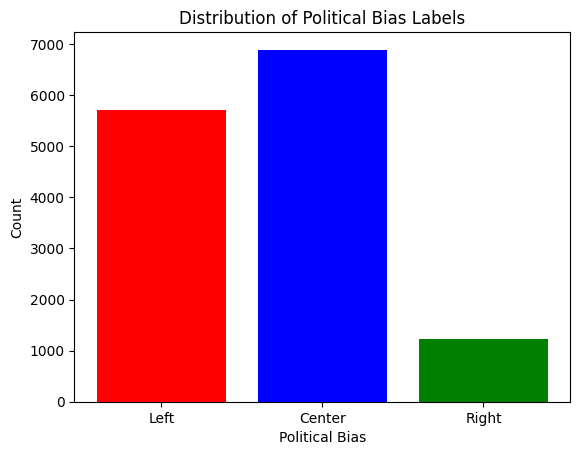

In [ ]:
# Calculating the value counts of the labels
label_counts = df['label'].value_counts().sort_index()
label_df = pd.DataFrame({
    'Political Bias': ['Left', 'Center', 'Right'],
    'Count': label_counts.values
})

colors = {'Left': 'red', 'Center': 'blue', 'Right': 'green'}

fig, ax = plt.subplots()
bars = ax.bar(label_df['Political Bias'], label_df['Count'], color=[colors[label] for label in label_df['Political Bias']])
ax.set_title('Distribution of Political Bias Labels')
ax.set_xlabel('Political Bias')
ax.set_ylabel('Count')
plt.show()

### 2. Word count in Title and Body by categories

In [ ]:
# Calculating the word count for titles and bodies
df['title_word_count'] = df['title'].apply(lambda x: len(str(x).split()))
df['body_word_count'] = df['body'].apply(lambda x: len(str(x).split()))

# Calculating overall statistics for title and body word count by label
title_word_count_stats = df.groupby('label')['title_word_count'].describe()
body_word_count_stats = df.groupby('label')['body_word_count'].describe()

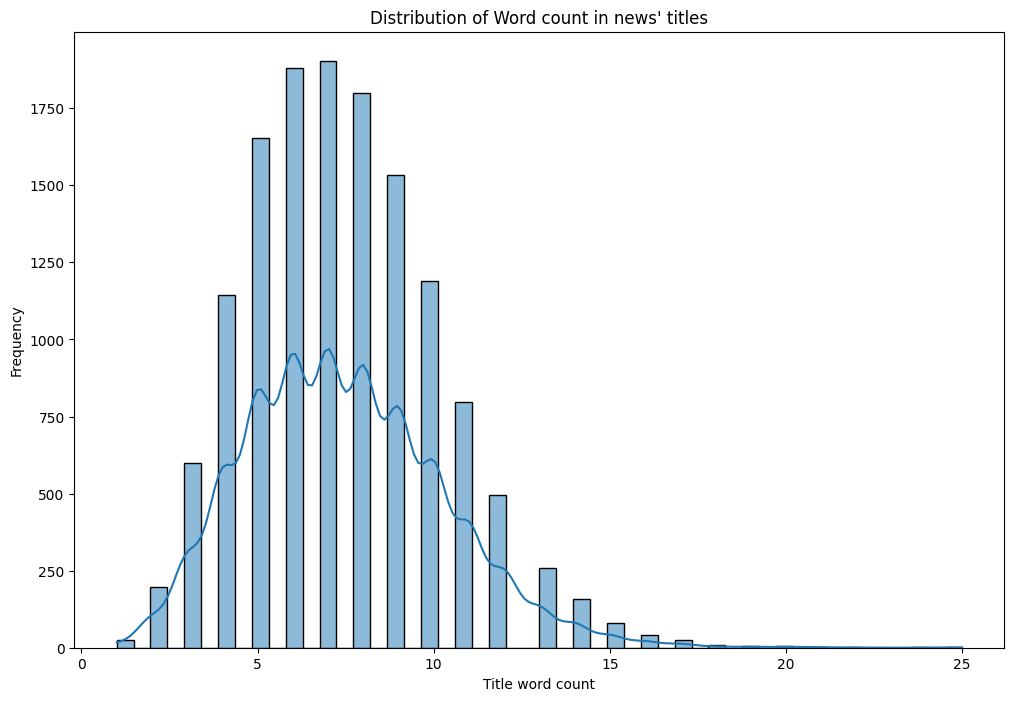

In [ ]:
# Plot the distribution of word count for titles
plt.figure(figsize=(12, 8))
sns.histplot(df['title_word_count'], bins=50, kde=True)
plt.xlabel('Title word count')
plt.ylabel('Frequency')
plt.title("Distribution of Word count in news' titles")
plt.show()

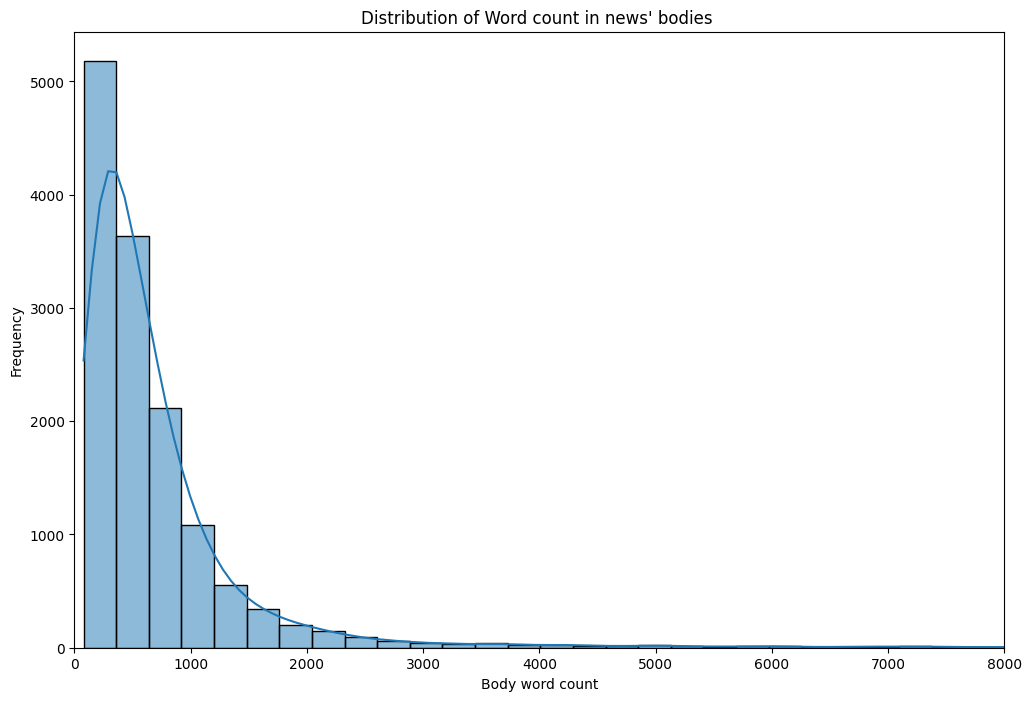

In [ ]:
# Plot the distribution of word count for bodies
plt.figure(figsize=(12, 8))
sns.histplot(df['body_word_count'], bins=50, kde=True)
plt.xlabel('Body word count')
plt.ylabel('Frequency')
plt.title("Distribution of Word count in news' bodies ")
plt.xlim(0, 8000)
plt.show()

In [ ]:
# overall statistics
print("Title Word Count Statistics by Label:")
print(title_word_count_stats)
print("\nBody Word Count Statistics by Label:")
print(body_word_count_stats)

Title Word Count Statistics by Label:
        count      mean       std  min  25%  50%  75%   max
label                                                      
0      5705.0  7.446801  2.833261  1.0  5.0  7.0  9.0  25.0
1      6889.0  7.519379  2.768079  1.0  5.0  7.0  9.0  25.0
2      1218.0  7.098522  2.771818  1.0  5.0  7.0  9.0  19.0

Body Word Count Statistics by Label:
        count         mean          std    min     25%    50%     75%      max
label                                                                         
0      5705.0  1034.311656  1551.898177   79.0  413.00  618.0   988.0  14111.0
1      6889.0   465.194368   586.001529   80.0  193.00  302.0   563.0  13930.0
2      1218.0  1083.063218   704.141727  100.0  572.25  908.0  1458.0   5482.0


In [ ]:
def plot_distribution(df, column, title, xlim=None):
    plt.figure(figsize=(12, 6))

    # Plotting histograms with light colors and KDE lines with dark, thick colors
    sns.histplot(df[df['label'] == 0][column], bins=30, kde=True, color='blue', label='Left', stat='density', alpha=0.10,
                 line_kws={'color': 'darkblue', 'linewidth': 2})
    sns.histplot(df[df['label'] == 1][column], bins=30, kde=True, color='green', label='Center', stat='density', alpha=0.10,
                 line_kws={'color': 'darkgreen', 'linewidth': 2})
    sns.histplot(df[df['label'] == 2][column], bins=30, kde=True, color='red', label='Right', stat='density', alpha=0.10,
                 line_kws={'color': 'darkred', 'linewidth': 2})

    plt.xlabel('Word Count')
    plt.ylabel('Density')
    plt.title(title)
    plt.legend()
    if xlim:
        plt.xlim(xlim)
    plt.show()

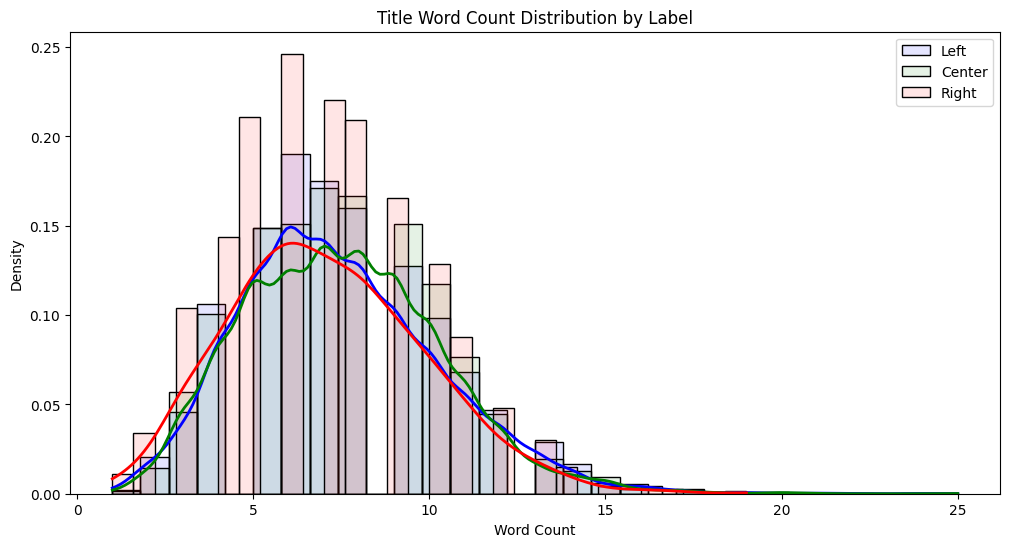

In [ ]:
# Plotting the word distribution for titles by label
plot_distribution(df, 'title_word_count', 'Title Word Count Distribution by Label')

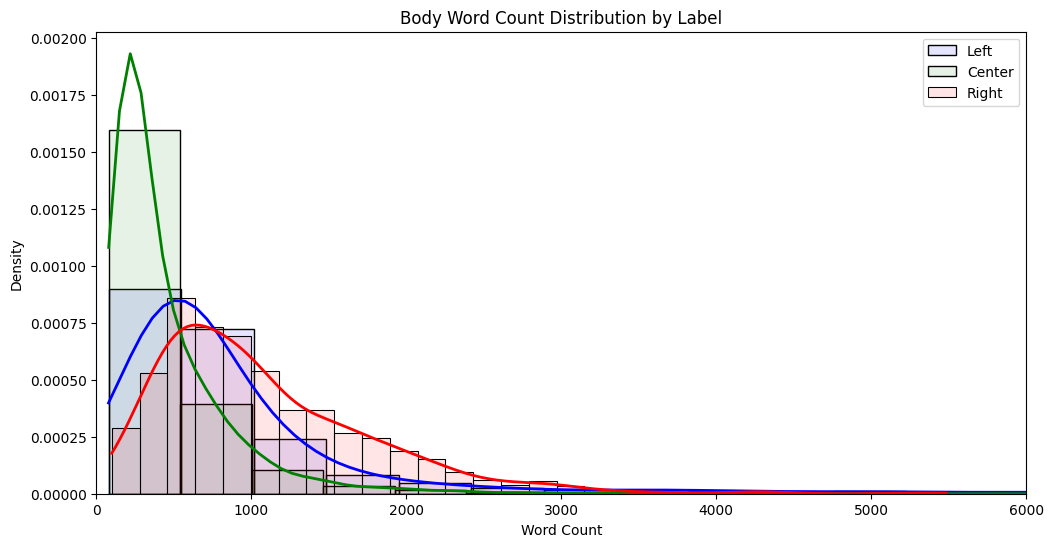

In [ ]:
# Plot the word distribution for bodies by label
plot_distribution(df, 'body_word_count', 'Body Word Count Distribution by Label', xlim=(0, 6000))

In [ ]:
#   violin plots and box plots
def plot_violin_box(df, column, title):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.violinplot(data=df, x='label', y=column, hue='label', palette='viridis', dodge=False, legend=False)
    plt.title(f'Violin Plot of {title}')
    plt.xlabel('Political Bias')
    plt.ylabel('Word Count')
    plt.xticks([0, 1, 2], ['Left', 'Center', 'Right'])

    plt.subplot(1, 2, 2)
    sns.boxplot(data=df, x='label', y=column, hue='label', palette='viridis', dodge=False, legend=False)
    plt.title(f'Box Plot of {title}')
    plt.xlabel('Political Bias')
    plt.ylabel('Word Count')
    plt.xticks([0, 1, 2], ['Left', 'Center', 'Right'])

    plt.tight_layout()
    plt.show()

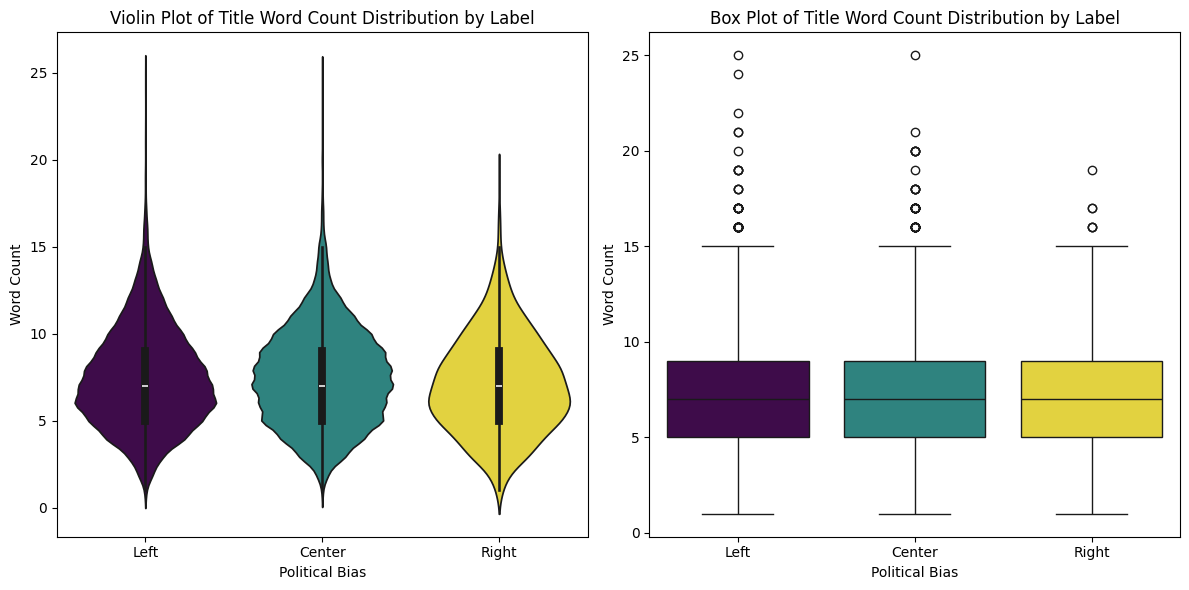

In [ ]:
# Plot the word distribution for titles by label
plot_violin_box(df, 'title_word_count', 'Title Word Count Distribution by Label')

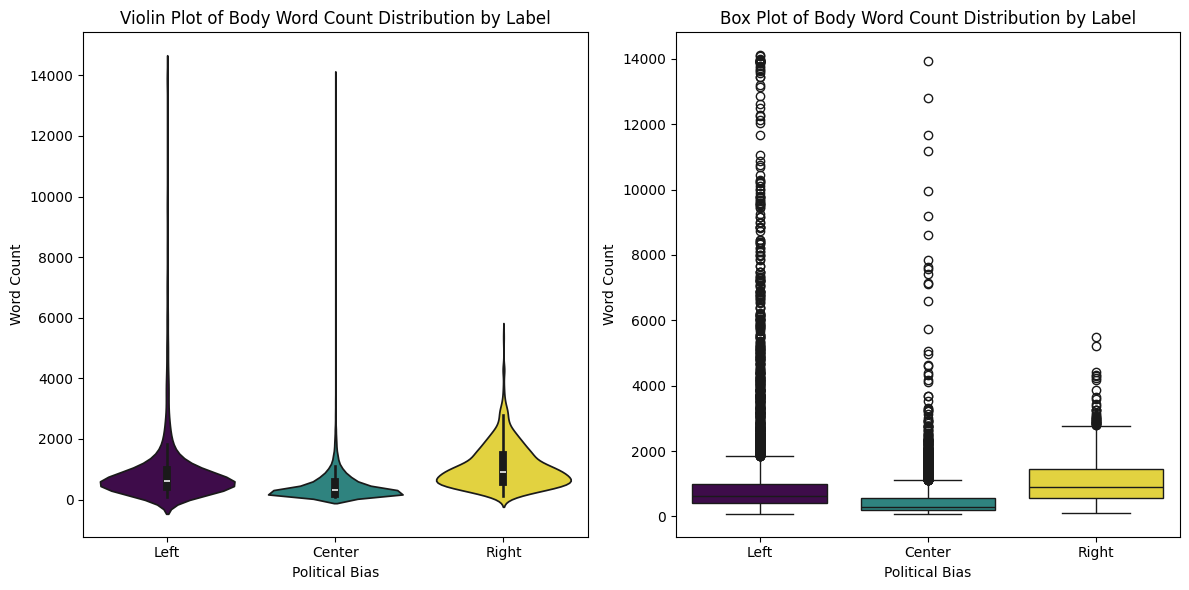

In [ ]:
plot_violin_box(df, 'body_word_count', 'Body Word Count Distribution by Label')

### 3. Average length of words per category (insights into the vocabulary’s complexity)

In [ ]:
# Calculating the average length of words for titles and bodies
def average_word_length(text):
    words = text.split()
    if len(words) == 0:
        return 0
    return sum(len(word) for word in words) / len(words)

df['title_avg_word_length'] = df['title'].apply(average_word_length)
df['body_avg_word_length'] = df['body'].apply(average_word_length)

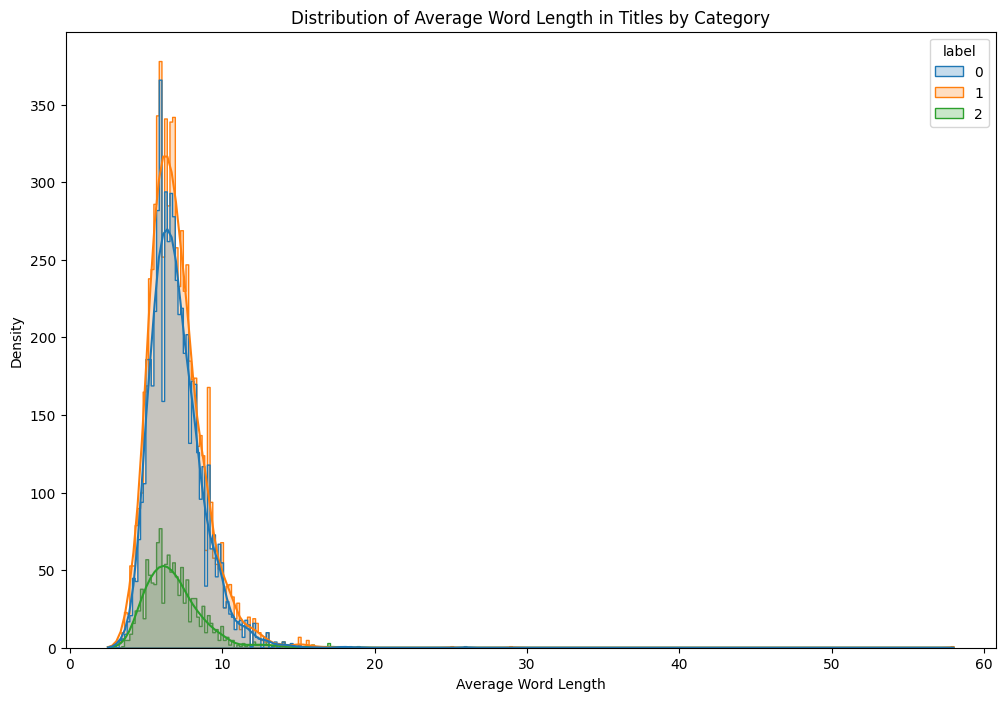

In [ ]:
# Plotting the distribution of the average length of words for titles per category of the label
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='title_avg_word_length', hue='label', kde=True, element='step', palette="tab10")
plt.title('Distribution of Average Word Length in Titles by Category')
plt.xlabel('Average Word Length')
plt.ylabel('Density')
plt.show()

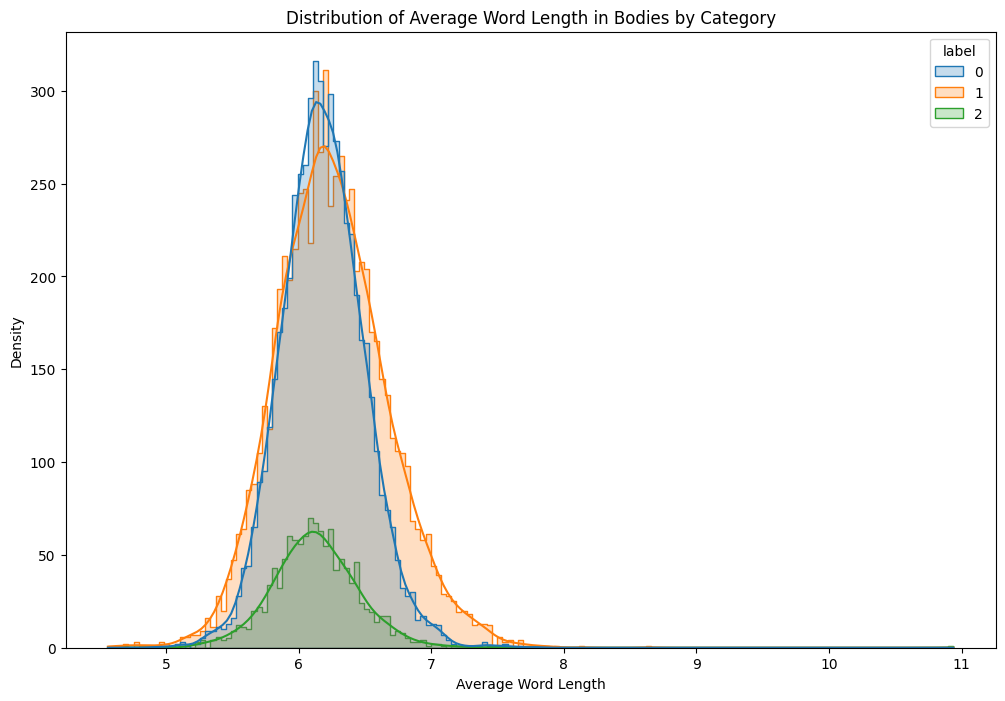

In [ ]:
# similarly for bodies
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='body_avg_word_length', hue='label', kde=True, element='step', palette='tab10')
plt.title('Distribution of Average Word Length in Bodies by Category')
plt.xlabel('Average Word Length')
plt.ylabel('Density')
plt.show()

In [ ]:
#  overall statistics for title and body average word length by label
title_avg_word_length_stats = df.groupby('label')['title_avg_word_length'].describe()
body_avg_word_length_stats = df.groupby('label')['body_avg_word_length'].describe()

In [ ]:
print("Average Word Length in Titles Statistics by Label:")
print(title_avg_word_length_stats)

Average Word Length in Titles Statistics by Label:
        count      mean       std  min       25%   50%       75%   max
label                                                                 
0      5705.0  6.981814  1.693093  3.0  5.818182  6.75  7.875000  26.0
1      6889.0  6.966686  1.868656  3.0  5.750000  6.70  7.875000  58.0
2      1218.0  6.842513  1.958054  2.5  5.500000  6.50  7.666667  19.0


In [ ]:
print("Average Word Length in Bodies Statistics by Label:")
print(body_avg_word_length_stats)


Average Word Length in Bodies Statistics by Label:
        count      mean       std       min       25%       50%       75%  \
label                                                                       
0      5705.0  6.183424  0.310579  4.916667  5.978578  6.174359  6.380531   
1      6889.0  6.249540  0.415922  4.563097  5.967123  6.224490  6.507788   
2      1218.0  6.130635  0.349318  4.692597  5.924138  6.118457  6.325679   

             max  
label             
0       7.786585  
1       8.655678  
2      10.936652  


### 4. Average sentence length for categories and whole dataset (by word count)

In [ ]:
label_mapping = {0: 'Left', 1: 'Center', 2: 'Right'}
def average_sentence_length(text):

    #Splitting each sentence into words
    sentences = re.split(r'[.!?]', text)
    sentences = [s.strip() for s in sentences if s.strip()]

    if len(sentences) == 0:
        return 0

    #Sum of the word counts of all sentences and dividing it by the number of sentences
    return sum(len(s.split()) for s in sentences) / len(sentences)

df['title_avg_sentence_length'] = df['title'].apply(average_sentence_length)
df['body_avg_sentence_length'] = df['body'].apply(average_sentence_length)

In [ ]:
# Calculating average sentence length per category
avg_sentence_length_per_category = df.groupby('label').agg({
    'title_avg_sentence_length': 'mean',
    'body_avg_sentence_length': 'mean'
}).rename(columns={
    'title_avg_sentence_length': 'avg_title_sentence_length',
    'body_avg_sentence_length': 'avg_body_sentence_length'
})

# Calculating average sentence length for the entire dataset
avg_title_sentence_length_total = df['title_avg_sentence_length'].mean()
avg_body_sentence_length_total = df['body_avg_sentence_length'].mean()

# Adding total averages to the DataFrame for plotting
total_avg_df = pd.DataFrame({
    'avg_title_sentence_length': [avg_title_sentence_length_total],
    'avg_body_sentence_length': [avg_body_sentence_length_total]
}, index=['Total'])

avg_sentence_length_per_category = pd.concat([avg_sentence_length_per_category, total_avg_df])
avg_sentence_length_per_category.index = avg_sentence_length_per_category.index.map(lambda x: label_mapping.get(x, x))

print("Average Sentence Length by Category:")
print(avg_sentence_length_per_category)

Average Sentence Length by Category:
        avg_title_sentence_length  avg_body_sentence_length
Left                     7.137596                 15.817960
Center                   7.245186                 15.515646
Right                    6.529693                 17.598005
Total                    7.137651                 15.824147


<ipython-input-235-cbdd127c7b64>:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-235-cbdd127c7b64>:8: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-235-cbdd127c7b64>:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-235-cbdd127c7b64>:15: UserWarning:

FixedFormatter should only be used together with FixedLocator



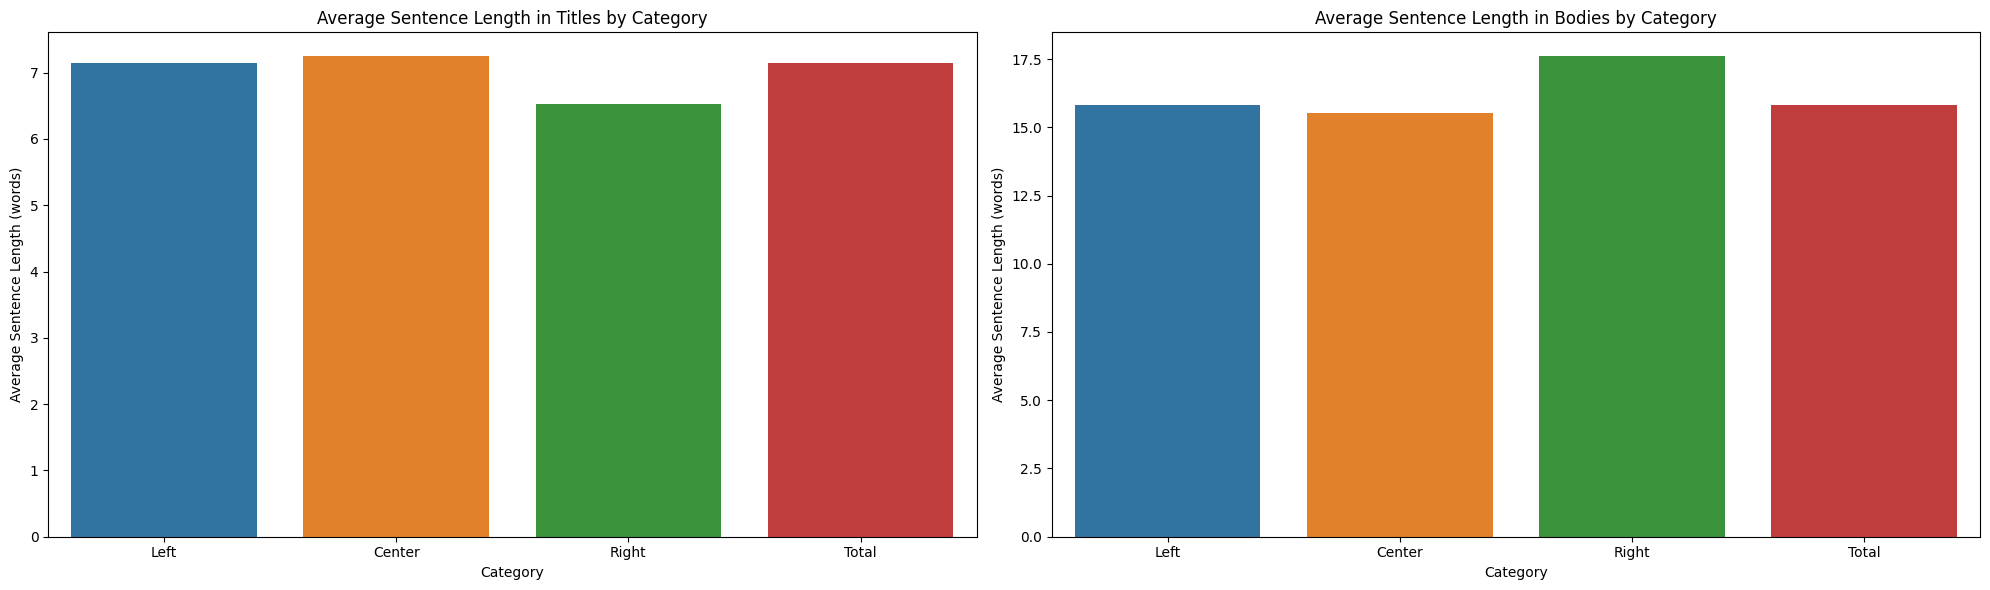

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plotting average sentence length per category for titles
sns.barplot(ax=axes[0], x=avg_sentence_length_per_category.index, y=avg_sentence_length_per_category['avg_title_sentence_length'], palette="tab10")
axes[0].set_title('Average Sentence Length in Titles by Category')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Average Sentence Length (words)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Plotting average sentence length per category for bodies
sns.barplot(ax=axes[1], x=avg_sentence_length_per_category.index, y=avg_sentence_length_per_category['avg_body_sentence_length'], palette="tab10")
axes[1].set_title('Average Sentence Length in Bodies by Category')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Average Sentence Length (words)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

### 5.Average number of sentences per category and whole dataset

In [ ]:
def sentence_count(text):
    sentences = re.split(r'[.!?]', text)
    sentences = [s.strip() for s in sentences if s.strip()]
    return len(sentences)

In [ ]:
# Calculating the number of sentences for titles and bodies
df['title_sentence_count'] = df['title'].apply(sentence_count)
df['body_sentence_count'] = df['body'].apply(sentence_count)

# Calculating the average number of sentences per category
avg_sentence_count_per_category = df.groupby('label').agg({
    'title_sentence_count': 'mean',
    'body_sentence_count': 'mean'
}).rename(columns={
    'title_sentence_count': 'avg_title_sentence_count',
    'body_sentence_count': 'avg_body_sentence_count'
})

# Calculating the average number of sentences for the entire dataset
avg_title_sentence_count_total = df['title_sentence_count'].mean()
avg_body_sentence_count_total = df['body_sentence_count'].mean()

total_avg_df = pd.DataFrame({
    'avg_title_sentence_count': [avg_title_sentence_count_total],
    'avg_body_sentence_count': [avg_body_sentence_count_total]
}, index=['Total'])

avg_sentence_count_per_category = pd.concat([avg_sentence_count_per_category, total_avg_df])
avg_sentence_count_per_category.index = avg_sentence_count_per_category.index.map(lambda x: label_mapping.get(x, x))

print("Average Sentence Count by Category:")
print(avg_sentence_count_per_category)

Average Sentence Count by Category:
        avg_title_sentence_count  avg_body_sentence_count
Left                    1.073795                68.484838
Center                  1.071563                31.012629
Right                   1.162562                62.967980
Total                   1.080510                49.308355


<ipython-input-238-7d4a6ae8d974>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




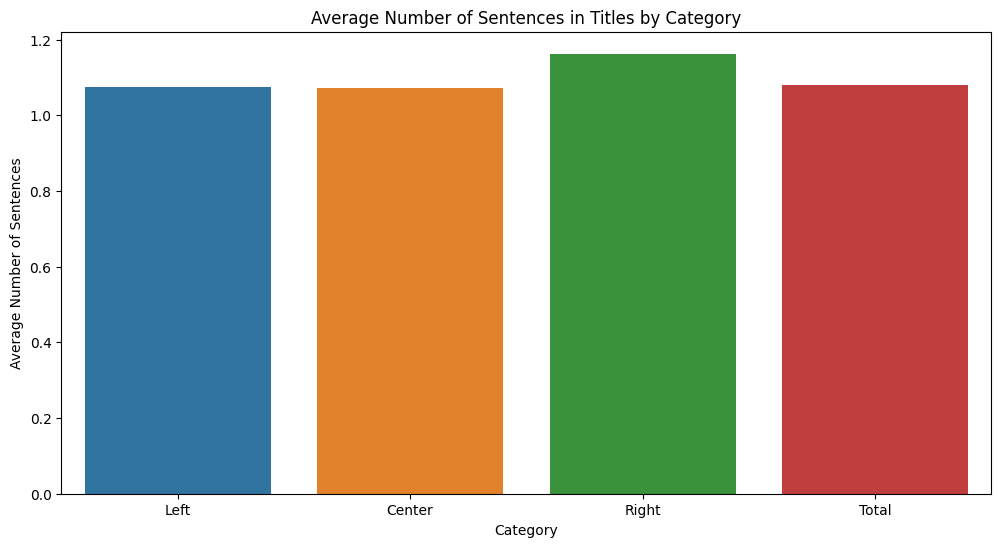

<ipython-input-238-7d4a6ae8d974>:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




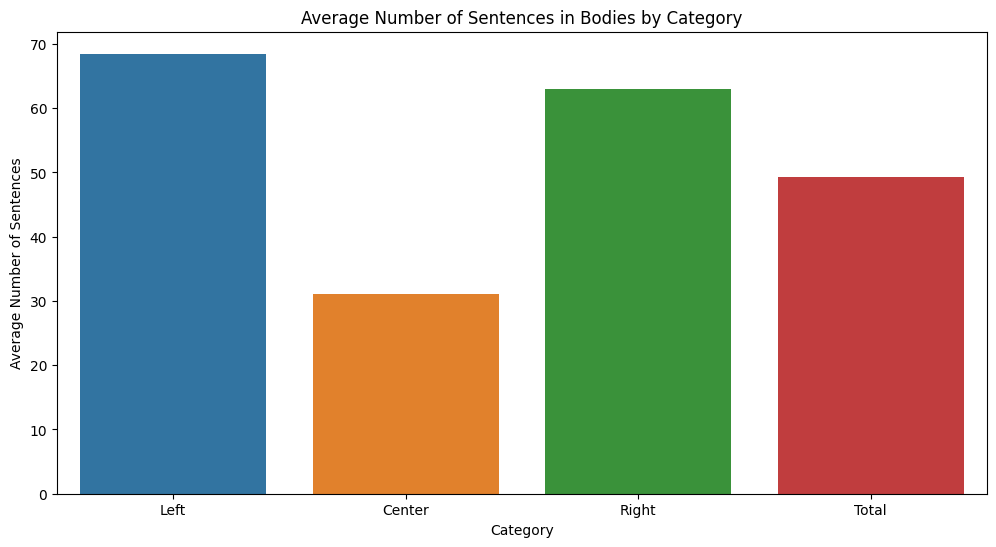

In [ ]:
# Plotting average sentence count per category for titles
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_sentence_count_per_category.index, y=avg_sentence_count_per_category['avg_title_sentence_count'], palette="tab10")
plt.title('Average Number of Sentences in Titles by Category')
plt.xlabel('Category')
plt.ylabel('Average Number of Sentences')
plt.xticks(rotation=0)
plt.show()

#  for bodies
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_sentence_count_per_category.index, y=avg_sentence_count_per_category['avg_body_sentence_count'], palette="tab10")
plt.title('Average Number of Sentences in Bodies by Category')
plt.xlabel('Category')
plt.ylabel('Average Number of Sentences')
plt.xticks(rotation=0)
plt.show()

### 6. The number of news articles mentioning each party


Number of News Articles about Each Party:
       count
AfD     3143
GRÜNE   3538
LINKE   2714
FDP     2029
SPD     4562
CDU     4623
CSU     2655


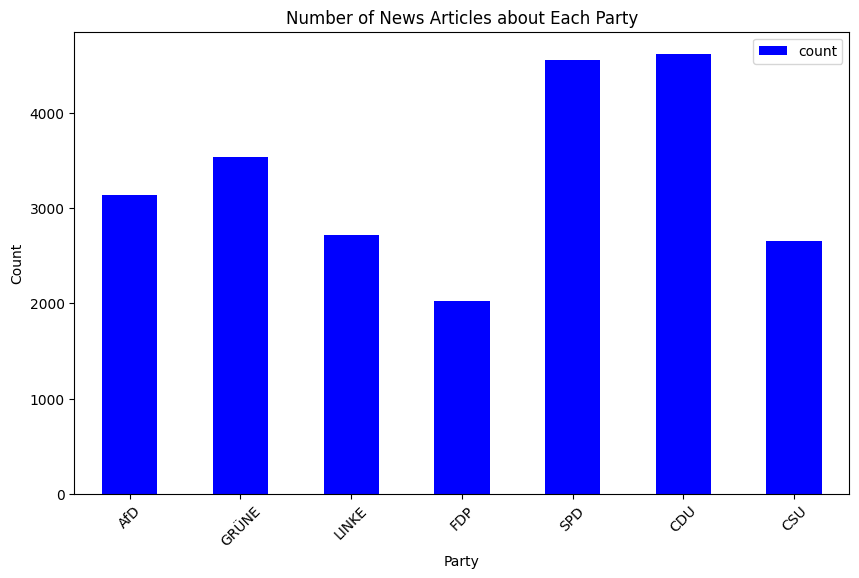

In [ ]:
# List of main German political parties
parties = ['AfD', 'GRÜNE', 'LINKE', 'FDP', 'SPD', 'CDU', 'CSU']

# Count the number of articles mentioning each party
party_counts = {party: df['body'].str.contains(party, case=False, na=False).sum() for party in parties}

party_counts_df = pd.DataFrame.from_dict(party_counts, orient='index', columns=['count'])
print("\nNumber of News Articles about Each Party:")
print(party_counts_df)


party_counts_df.plot(kind='bar', figsize=(10, 6), color='blue')
plt.title('Number of News Articles about Each Party')
plt.xlabel('Party')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

To accurately analyze the vocabulary, we must preprocess the text data firstly. Without preprocessing, identical words might be treated as different words, skewing the statistics. For example, without punctuation removal "gewählt" and "gewählt." will be counted seperately.

### Task 2: Data Preprocessing

In [ ]:
nltk.download('stopwords')
# stop words for German
stop_words = set(stopwords.words('german'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Applied Preprocessing Techniques**

1. The text is filtered to retain only ASCII characters and German-specific letters (ä, ö, ü, Ä, Ö, Ü, ß), while all other characters are removed.
2. Single letter characters are removed to eliminate noise.
3. All whitespace is converted to single spaces to ensure uniformity.
4. Punctuation marks and special characters are removed to focus on the textual content.
5. Stop words are removed.
6. The text is lemmatized to reduce words to their base form for better analysis.

In [ ]:
def clean_text(text):

    # Keep only ASCII characters and German specific letters
    text = re.sub(r'[^a-zA-ZäöüÄÖÜß\s]', '', text)

    # Remove single letter characters
    text = re.sub(r'\b\w\b', '', text)

    # Convert all whitespace to single spaces
    text = ' '.join(text.split())

    # Remove punctuation marks(including special characters)
    #text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[^\w\säöüÄÖÜß]', '', text)

    # Remove stop words and lemmatize
    doc = nlp(text)
    text = ' '.join([token.lemma_ for token in doc if token.text.lower() not in stop_words])

    return text

In [ ]:
# Apply cleaning function to title and body
df['title_cleaned'] = df['title'].apply(clean_text)
df['body_cleaned'] = df['body'].apply(clean_text)

In [ ]:
# Verifying the cleaning process
print("Sample cleaned titles and bodies:")
print(df[['title', 'title_cleaned']].head())

Sample cleaned titles and bodies:
                                               title  \
0  Schulz: Gratisflüge mit EU-Jets für's Parteive...   
1  Sachsen hat gewählt: Der Krimi um die leeren A...   
2  SNP-Chefin greift Boris Johnson an - und forde...   
3        Siemens-Chef Kaeser will nach Saudi-Arabien   
4  "Maybrit Illner": Kanzleramtschef Altmaier ver...   

                                       title_cleaned  
0        Schulz Gratisflüge EUJets für Parteivergnüg  
1       Sachsen wählen Krimi leer AfDSitze Parlament  
2  SNPChefin greifen Boris Johnson fordern neu Br...  
3                    SiemensChef Kaeser SaudiArabien  
4  Maybrit Illner Kanzleramtschef Altmaier vertei...  


In [ ]:
print(df[['body', 'body_cleaned']].head())

                                                body  \
0  Schulz: Gratisflüge mit EU-Jets für's Parteive...   
1  Von: Sören Haberlandt und Michael Kruse\nIrrer...   
2  SNP-Chefin greift Boris Johnson an - und forde...   
3  Siemens-Chef Kaeser will nach Saudi-Arabien\nA...   
4  Die von der SPD lange abgelehnte Große Koaliti...   

                                        body_cleaned  
0  Schulz Gratisflüge EUJets für Parteivergnüg Kr...  
1  Sören Haberlandt Michael Kruse Irrer Krimi Zah...  
2  SNPChefin greifen Boris Johnson fordern neu Br...  
3  SiemensChef Kaeser SaudiArabien angesichts imm...  
4  SPD lange abgelehnt groß Koalition immer wahrs...  


### 2. Analysis of number of unique words in different categories of label and in whole dataset

In [ ]:
def unique_word_count(texts):
    unique_words = set()
    for text in texts:
        unique_words.update(str(text).split())
    return len(unique_words)


unique_word_counts_by_category = df.groupby('label').agg({
    'title_cleaned': lambda x: unique_word_count(x),
    'body_cleaned': lambda x: unique_word_count(x)
}).rename(columns={'title_cleaned': 'unique_title_words', 'body_cleaned': 'unique_body_words'})

In [ ]:
print("Unique Word Count by Category:")
print(unique_word_counts_by_category)

Unique Word Count by Category:
       unique_title_words  unique_body_words
label                                       
0                    9387             149048
1                   11079             116846
2                    3153              84746


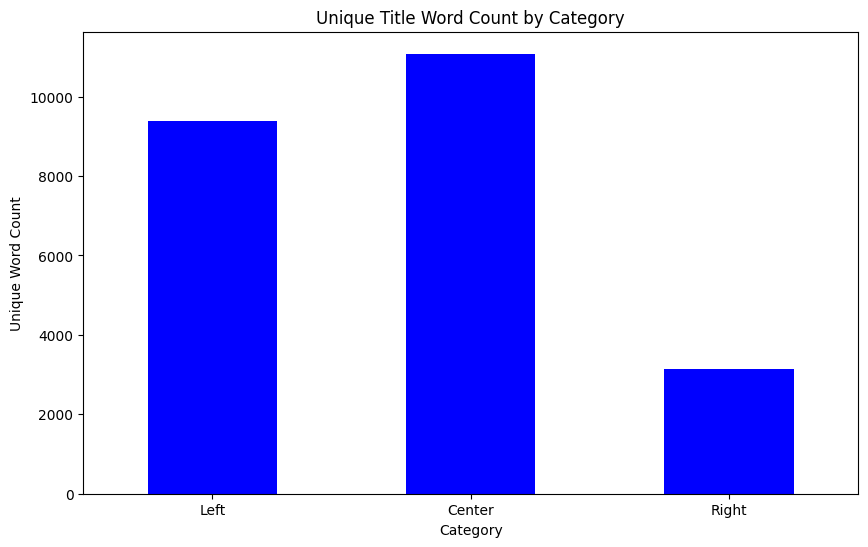

In [ ]:
# Plot unique word counts for titles by category
unique_word_counts_by_category['unique_title_words'].plot(kind='bar', figsize=(10, 6), color='blue')
plt.title('Unique Title Word Count by Category')
plt.xlabel('Category')
plt.ylabel('Unique Word Count')
plt.xticks([0, 1, 2], ['Left', 'Center', 'Right'], rotation=0)
plt.show()

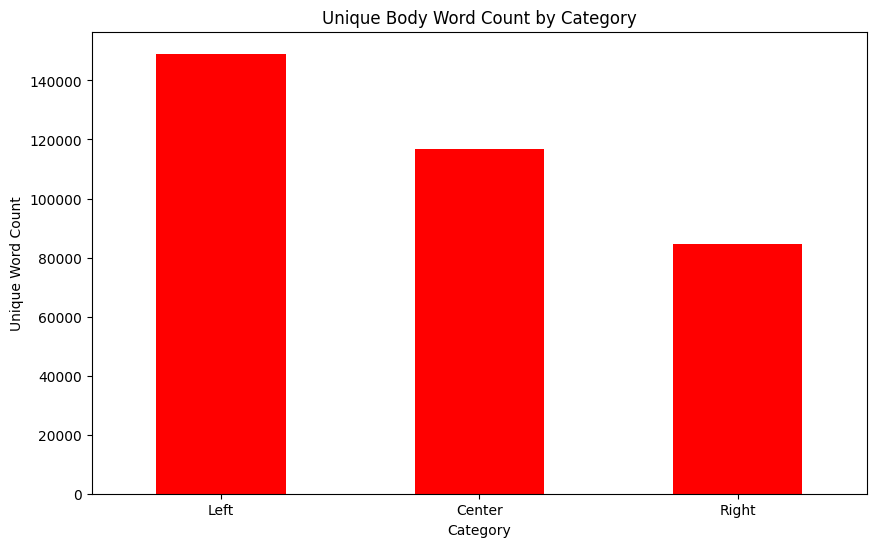

In [ ]:
# Plot unique word counts for bodies by category
unique_word_counts_by_category['unique_body_words'].plot(kind='bar', figsize=(10, 6), color='red')
plt.title('Unique Body Word Count by Category')
plt.xlabel('Category')
plt.ylabel('Unique Word Count')
plt.xticks([0, 1, 2], ['Left', 'Center', 'Right'], rotation=0)
plt.show()

In [ ]:
#number of unique words for whole dataset
unique_words_title = unique_word_count(df['title_cleaned'])
unique_words_body = unique_word_count(df['body_cleaned'])

print("\nUnique Words in Titles: ", unique_words_title)
print("Unique Words in Bodies: ", unique_words_body)


Unique Words in Titles:  17871
Unique Words in Bodies:  240008


### 3. The most common n-grams in the dataset

In [ ]:
# cleaned title and body together
df['text_cleaned'] = df['title_cleaned'] + " " + df['body_cleaned']
# Combine all cleaned text for  frequency analysis
all_text = ' '.join(df['text_cleaned'])

In [ ]:
# Function to get top n-grams
def get_top_n_grams(corpus,stop_words, n=10, ngram_range=(1, 1)):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words=stop_words).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [ ]:
# top unigrams, bigrams, and trigrams
stop_words = list(stop_words) #converting set to list
top_unigrams = get_top_n_grams(df['text_cleaned'],stop_words, n=25, ngram_range=(1, 1))
top_bigrams = get_top_n_grams(df['text_cleaned'], stop_words , n=25, ngram_range=(2, 2))
top_trigrams = get_top_n_grams(df['text_cleaned'],stop_words, n=25, ngram_range=(3, 3))


unigrams_df = pd.DataFrame(top_unigrams, columns=['word', 'count'])
bigrams_df = pd.DataFrame(top_bigrams, columns=['word', 'count'])
trigrams_df = pd.DataFrame(top_trigrams, columns=['word', 'count'])

<ipython-input-253-2851572a0640>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




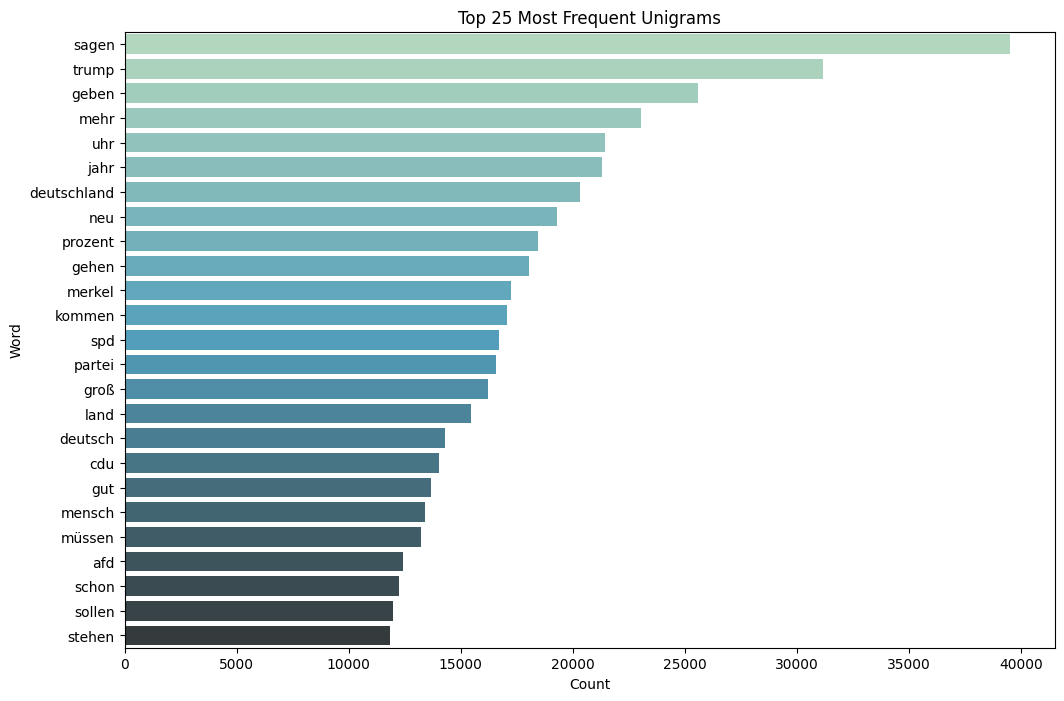

In [ ]:
# Plotting top 25 unigrams
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='word', data=unigrams_df, palette='GnBu_d')
plt.title('Top 25 Most Frequent Unigrams')
plt.xlabel('Count')
plt.ylabel('Word')
plt.show()

<ipython-input-254-b67046a7ae05>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




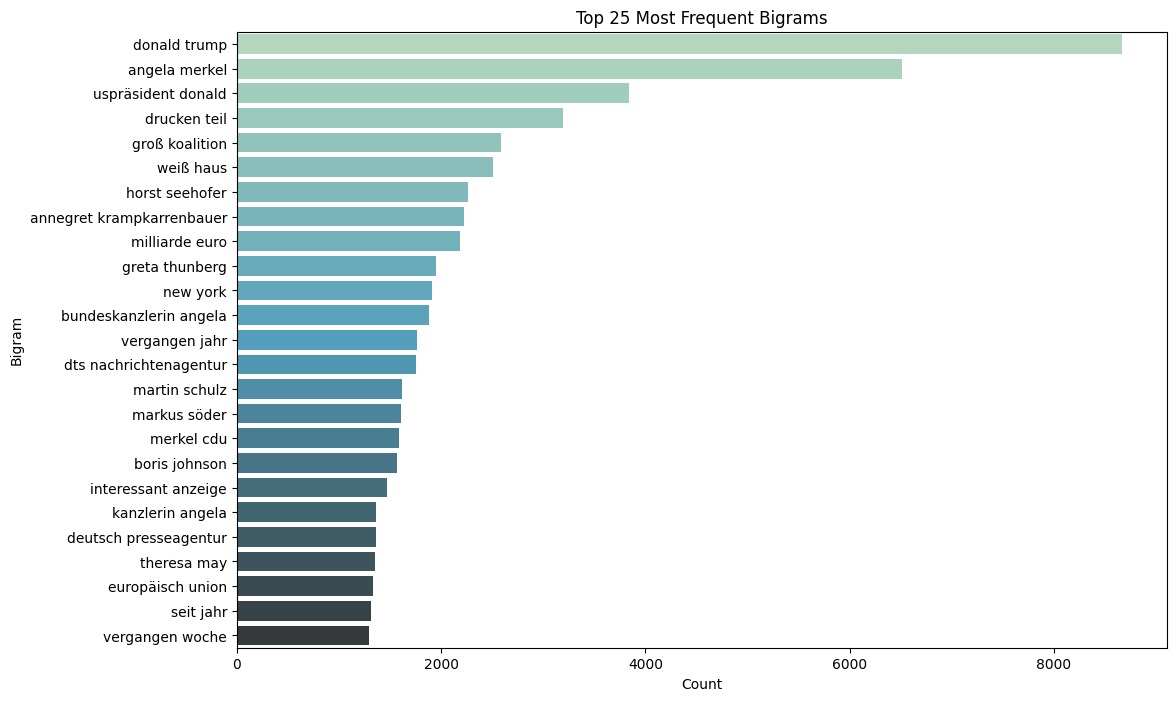

In [ ]:
# Plotting top 25 bigrams
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='word', data=bigrams_df, palette='GnBu_d')
plt.title('Top 25 Most Frequent Bigrams')
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.show()

<ipython-input-255-24d115d4012e>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




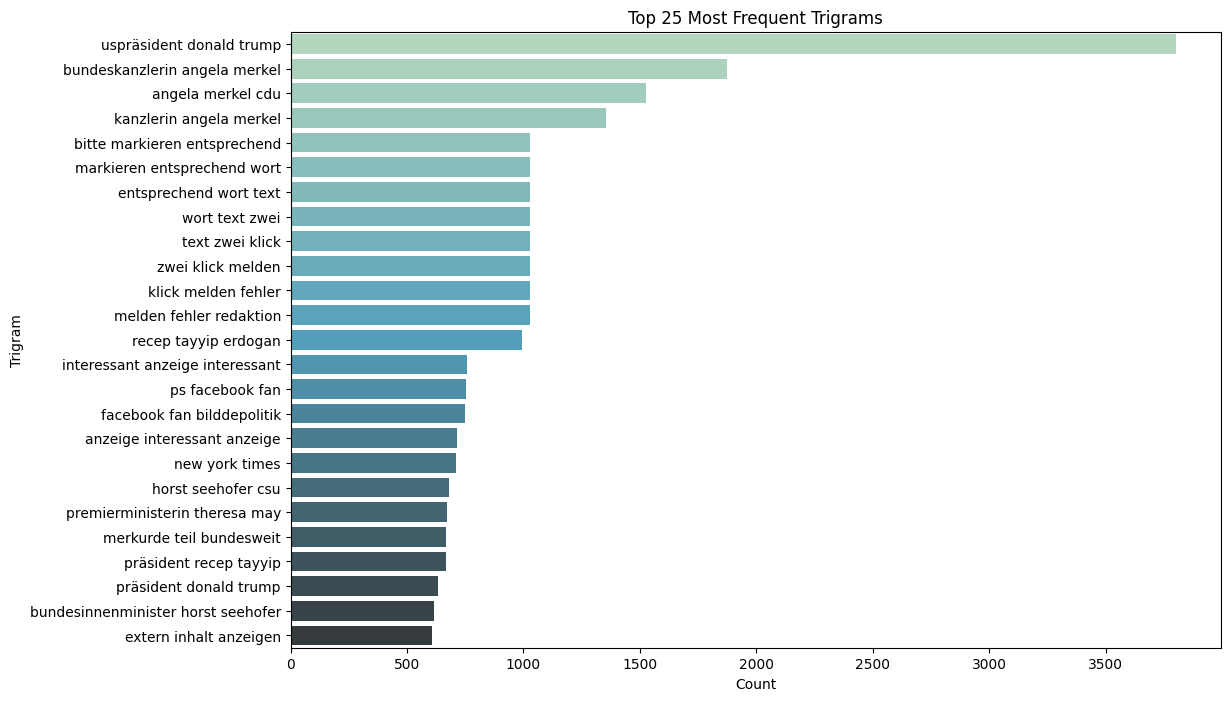

In [ ]:
# Plotting top 25 trigrams
plt.figure(figsize=(12, 8))
sns.barplot(x='count', y='word', data=trigrams_df, palette='GnBu_d')
plt.title('Top 25 Most Frequent Trigrams')
plt.xlabel('Count')
plt.ylabel('Trigram')
plt.show()

### Task 3: Text classification

##### Preprocessing Methods/Options

In [ ]:
# stop words for German
stop_words = set(stopwords.words('german'))

# Modified cleaning function with options for preprocessing as lemmatization and stop word removal
def clean_text(text, lemmatize=False, remove_stopwords=False, remove_non_ascii=False):
    if remove_non_ascii:
        # Keep only ASCII characters and German specific letters
        text = re.sub(r'[^a-zA-ZäöüÄÖÜß\s]', '', text)

    # Remove single letter characters
    text = re.sub(r'\b\w\b', '', text)

    # Convert all whitespace to single spaces
    text = ' '.join(text.split())

    # Remove punctuation marks (including special characters)
    text = re.sub(r'[^\w\säöüÄÖÜß]', '', text)

    # Lemmatize if specified
    if lemmatize:
        doc = nlp(text)
        text = ' '.join([token.lemma_ for token in doc])

    # Remove stop words if specified
    if remove_stopwords:
        text = ' '.join([word for word in text.split() if word.lower() not in stop_words])

    return text

##### Model training

In [ ]:
# Train and evaluate Naive Bayes model
def train_naive_bayes(X_train_vect, y_train, X_test_vect, y_test):
    nb_model = MultinomialNB()
    nb_model.fit(X_train_vect, y_train)
    y_pred = nb_model.predict(X_test_vect)
    print("Naive Bayes Classification Report:")
    print(classification_report(y_test, y_pred))
    return f1_score(y_test, y_pred, average='weighted') #f-1 for multiclass

# Train and evaluate FFNN
def train_neural_network(X_train_vect, y_train, X_test_vect, y_test):
    nn_model =  MLPClassifier(random_state=42, max_iter=100, hidden_layer_sizes=(50,), batch_size=64, early_stopping=True)
    nn_model.fit(X_train_vect, y_train)
    y_pred = nn_model.predict(X_test_vect)
    print("Neural Network Classification Report:")
    print(classification_report(y_test, y_pred))
    return f1_score(y_test, y_pred, average='weighted')

In [ ]:
#Word2Vec
def train_word2vec(corpus):
    from gensim.models import Word2Vec
    tokenized_corpus = [text.split() for text in corpus]
    w2v_model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)
    return w2v_model

def word2vec_features(corpus, model):
    def get_avg_word2vec(tokens, model, vector_size):
        feature_vec = np.zeros((vector_size,), dtype="float32")
        num_words = 0
        for word in tokens:
            if word in model.wv:
                num_words += 1
                feature_vec = np.add(feature_vec, model.wv[word])
        if num_words > 0:
            feature_vec = np.divide(feature_vec, num_words)
        return feature_vec

    vector_size = model.vector_size
    features = [get_avg_word2vec(text.split(), model, vector_size) for text in corpus]
    return np.array(features)

##### Comparison and Analysis

In [ ]:
results = {}

# Vectorization methods to test
vectorizers = {
    'Count Vectorizer': CountVectorizer(max_features=5000, min_df=3, max_df=0.90),  #bag_of_words
    'TF-IDF Vectorizer': TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=3, max_df=0.90), #tf-idf
    'N-gram Vectorizer': CountVectorizer(max_features=5000, ngram_range=(1,2), min_df=3, max_df=0.90), #bag of n-grams
    'Word2Vec': None  # Special case
}

# Preprocessing options
preprocessing_options = [
    {'lemmatize': False, 'remove_stopwords': False, 'remove_non_ascii': False,},
    {'lemmatize': False, 'remove_stopwords': True, 'remove_non_ascii': True},
    # Only lemmatize in the last check, as it takes too much time
    {'lemmatize': True, 'remove_stopwords': True, 'remove_non_ascii': True}
]

In [ ]:
# Evaluating each combination of preprocessing and vectorization for both models
for vectorizer_name, vectorizer in vectorizers.items():
    for options in preprocessing_options:
        df['text_cleaned'] = df['title'] + " " + df['body']
        df['text_cleaned'] = df['text_cleaned'].apply(lambda x: clean_text(x, **options))

        # Splitting the data
        X = df['text_cleaned']
        y = df['label']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        # Vectorizing text
        if vectorizer_name == 'Word2Vec':
            w2v_model = train_word2vec(X_train)
            X_train_vect = word2vec_features(X_train, w2v_model)
            X_test_vect = word2vec_features(X_test, w2v_model)

            #Normalization was applied to vectors for the Naive Bayes model to handle non-negative values.
            scaler = MinMaxScaler()
            X_train_vect_nb = scaler.fit_transform(X_train_vect)
            X_test_vect_nb = scaler.transform(X_test_vect)

            # Handling class imbalance by undersampling
            undersampler = RandomUnderSampler(random_state=42)
            X_train_res_nb, y_train_res_nb = undersampler.fit_resample(X_train_vect_nb, y_train)

            # Naive Bayes
            nb_f1 = train_naive_bayes(X_train_res_nb, y_train_res_nb, X_test_vect_nb, y_test)

            # Neural Network
            X_train_res_nn, y_train_res_nn = undersampler.fit_resample(X_train_vect, y_train)
            nn_f1 = train_neural_network(X_train_res_nn, y_train_res_nn, X_test_vect, y_test)
        else:
            X_train_vect = vectorizer.fit_transform(X_train)
            X_test_vect = vectorizer.transform(X_test)

            # Handling class imbalance by undersampling
            undersampler = RandomUnderSampler(random_state=42)
            X_train_res, y_train_res = undersampler.fit_resample(X_train_vect, y_train)

            # Naive Bayes
            nb_f1 = train_naive_bayes(X_train_res, y_train_res, X_test_vect, y_test)

            # Neural Network
            nn_f1 = train_neural_network(X_train_res, y_train_res, X_test_vect, y_test)


        key = f"{vectorizer_name} | Lemmatize: {options['lemmatize']} | Remove Stopwords: {options['remove_stopwords']} | Remove Non-ASCII: {options['remove_non_ascii']}"
        print(f"{vectorizer_name} | Lemmatize: {options['lemmatize']} | Remove Stopwords: {options['remove_stopwords']} | Remove Non-ASCII: {options['remove_non_ascii']}")
        results[key] = {'Naive Bayes F1': nb_f1, 'Neural Network F1': nn_f1}

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.69      0.73      1141
           1       0.82      0.71      0.76      1378
           2       0.38      0.86      0.53       244

    accuracy                           0.71      2763
   macro avg       0.66      0.75      0.67      2763
weighted avg       0.76      0.71      0.73      2763

Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1141
           1       0.89      0.76      0.82      1378
           2       0.55      0.87      0.68       244

    accuracy                           0.80      2763
   macro avg       0.75      0.82      0.77      2763
weighted avg       0.82      0.80      0.81      2763

Count Vectorizer | Lemmatize: False | Remove Stopwords: False | Remove Non-ASCII: False
Naive Bayes Classification Report:
              precision    recall  f1-scor

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.59      0.57      1141
           1       0.65      0.38      0.48      1378
           2       0.26      0.78      0.39       244

    accuracy                           0.50      2763
   macro avg       0.49      0.58      0.48      2763
weighted avg       0.58      0.50      0.51      2763

Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.60      0.65      1141
           1       0.74      0.66      0.70      1378
           2       0.37      0.84      0.52       244

    accuracy                           0.65      2763
   macro avg       0.60      0.70      0.62      2763
weighted avg       0.69      0.65      0.66      2763

Word2Vec | Lemmatize: False | Remove Stopwords: False | Remove Non-ASCII: False
Naive Bayes Classification Report:
              precision    recall  f1-score   supp

In [ ]:
results_df = pd.DataFrame(results)
print(results_df)

                   Count Vectorizer | Lemmatize: False | Remove Stopwords: False | Remove Non-ASCII: False  \
Naive Bayes F1                                              0.727019                                         
Neural Network F1                                           0.807623                                         

                   Count Vectorizer | Lemmatize: False | Remove Stopwords: True | Remove Non-ASCII: True  \
Naive Bayes F1                                              0.725735                                       
Neural Network F1                                           0.809751                                       

                   Count Vectorizer | Lemmatize: True | Remove Stopwords: True | Remove Non-ASCII: True  \
Naive Bayes F1                                              0.719171                                      
Neural Network F1                                           0.808403                                      

                   TF-

# Analysis of Errors


For the analysis of errors, we focus on models trained with the TF-IDF vectorization method and all preprocessing techniques applied.

In [ ]:
df['text_cleaned'] = df['title'] + " " + df['body']
df['text_cleaned'] = df['text_cleaned'].apply(lambda x: clean_text(x, lemmatize=True, remove_stopwords=True, remove_non_ascii=True))

In [ ]:
# Splitting into train and test sets
X = df['text_cleaned']
y_binary = (df['label'] == 1).astype(int)  # binary setup: 1 for center, 0 for left or right
y_multiclass = df['label']

X_df = pd.DataFrame(X, columns=['text_cleaned'])

# Undersampling the binary dataset
rus = RandomUnderSampler(random_state=42)
X_resampled_binary, y_resampled_binary = rus.fit_resample(X_df, y_binary)
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(X_resampled_binary['text_cleaned'], y_resampled_binary, test_size=0.2, random_state=42)

# Undersampling the multiclass dataset
X_resampled_multiclass, y_resampled_multiclass = rus.fit_resample(X_df, y_multiclass)
X_train_multiclass, X_test_multiclass, y_train_multiclass, y_test_multiclass = train_test_split(X_resampled_multiclass['text_cleaned'], y_resampled_multiclass, test_size=0.2, random_state=42)

# Vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2, max_df=0.95)
X_train_vect_binary = vectorizer.fit_transform(X_train_binary)
X_test_vect_binary = vectorizer.transform(X_test_binary)
X_train_vect_multiclass = vectorizer.fit_transform(X_train_multiclass)
X_test_vect_multiclass = vectorizer.transform(X_test_multiclass)

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Function to get misclassified examples
def get_misclassified_examples(X_test, y_test, y_pred):
    misclassified_indices = np.where(y_test != y_pred)[0]  #where the predicted class does not match true one
    misclassified_examples = X_test.iloc[misclassified_indices]
    return misclassified_examples, y_test.iloc[misclassified_indices], y_pred[misclassified_indices]

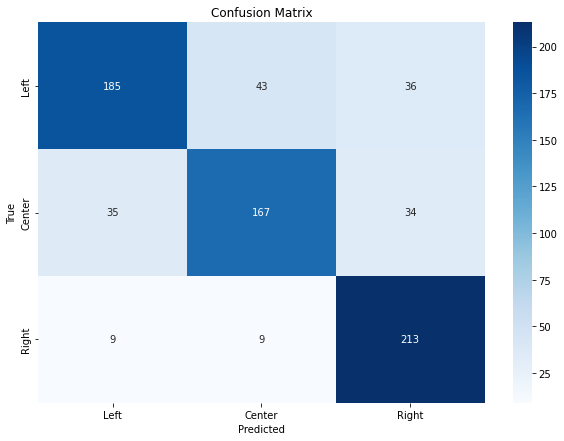

Misclassified examples for Naive Bayes:
Text: Sexualstrafrecht Kind reden Missbrauchsfall Staufen Vertrauen Behörde Justiz erschüttern klein Junge eigen Mutter Freund schwer Weise sexuell missbraucht weit Täter Geld Internet angeboten obwohl Haupttäter Aufsicht stehen Jugendamt immer Kind Mutter befasst Schuldige inzwischen lang Haftstrafen verurteilen politisch Fall jedoch abschließen Konsequenz Land BadenWürttemberg mehrer Gesetz ändern lassen Gerichtsverfahren Kindeswohlgefährdung verbessern Bundesland setzen Forderung Kommission Fachleute Monat erarbeiten Fall Staufen lagen damals eigentlich all Information Tisch allerdings Problem mehrer Tisch Bewährungshilfe Polizei Jugendamt mehrer Gericht Fall befasst niemand Bild zusammensetzen Kind furchtbar Lage befreien ExpertenKommission Kinderschutz Abschlussbericht Chronologie Versagen vorangestellt lassen Empfehlung verstehen Unheil beginnen Ende damals Junge sechs Jahr alt Mutter lernen Sexualstraftäter kennen wenig Monat zuvor Gefängn

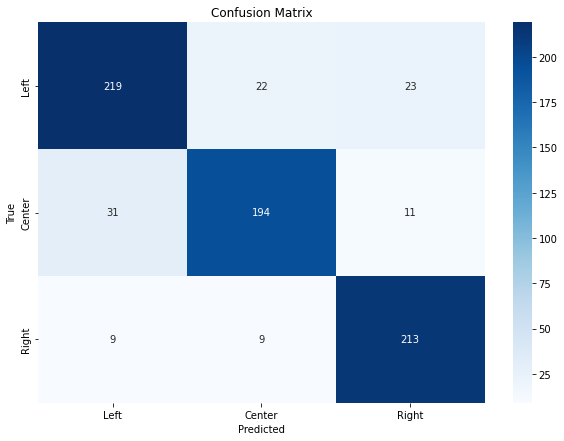

Misclassified examples for Neural Network:
Text: Auftragsmord Berliner Park Russischer Killer offenbaren Komplize Berliner Tiergartenmord inzwischen Anklage erheben August Zelimkhan Khangoshvili mutmaßlich Berufskiller erschießen Zelimkhan Khangoshvili Georgier tschetschenischen Wurzel August Berliner Park Kleiner Tiergarten erschießen mutmaßlich Mörder Vadim Krasikov alias Vadim Sokolov Auftrag russisch Regierung handeln gut Woche Anklage erheben Bundeskriminalamt Bundesanwaltschaft weit Russe ausmachen Vorbereitung Mord Kleine Tiergarten Berlin beteiligen berichten Spiegel Plattform Bellingcat Roman Visum wenig Woche Tat EU einreisen verdächtigen Datum angeben weise auffällig Parallelen Datum mutmaßlich AuftragsMörder Krasikov Tarnidentität benutzen beid stellen selben Tag Visumantrag behaupten Ingenieur Sankt Petersburg ansässig Firma arbeiten deutsch Ermittler vermuten Tarnunternehmen Verbindung russisch Geheimdienstapparat handeln welch Verbindung genau geben Krasikov konkret behi

In [ ]:
class_labels = ['Left', 'Center', 'Right']

# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_vect_multiclass, y_train_multiclass)
y_pred_nb = nb_model.predict(X_test_vect_multiclass)

# confusion matrix for Naive Bayes
plot_confusion_matrix(y_test_multiclass, y_pred_nb, class_labels)

# misclassified examples for Naive Bayes
misclassified_examples_nb, true_labels_nb, predicted_labels_nb = get_misclassified_examples(X_test_multiclass, y_test_multiclass, y_pred_nb)

# printing a few misclassified examples for Naive Bayes
print("Misclassified examples for Naive Bayes:")
for i in range(5):
    print(f"Text: {misclassified_examples_nb.iloc[i]}")
    print(f"True Label: {class_labels[true_labels_nb.iloc[i]]}")
    print(f"Predicted Label: {class_labels[predicted_labels_nb[i]]}\n")

# FFNN
nn_model = MLPClassifier(random_state=42, max_iter=300)
nn_model.fit(X_train_vect_multiclass, y_train_multiclass)
y_pred_nn = nn_model.predict(X_test_vect_multiclass)

#  confusion matrix for FFNN
plot_confusion_matrix(y_test_multiclass, y_pred_nn, class_labels)

#  misclassified examples for FFNN
misclassified_examples_nn, true_labels_nn, predicted_labels_nn = get_misclassified_examples(X_test_multiclass, y_test_multiclass, y_pred_nn)

# printing a few misclassified examples for FFNN
print("Misclassified examples for Neural Network:")
for i in range(5):
    print(f"Text: {misclassified_examples_nn.iloc[i]}")
    print(f"True Label: {class_labels[true_labels_nn.iloc[i]]}")
    print(f"Predicted Label: {class_labels[predicted_labels_nn[i]]}\n")

In [ ]:
# Function to calculate error statistics
def calculate_error_statistics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    error_stats = {}
    for i, label in enumerate(class_labels):
        true_positive = cm[i, i]
        false_positive = cm[:, i].sum() - true_positive
        false_negative = cm[i, :].sum() - true_positive
        error_stats[label] = {
            'True Positive': true_positive,
            'False Positive': false_positive,
            'False Negative': false_negative,
            'Error Rate': (false_positive + false_negative) / cm.sum()
        }
    return error_stats

In [ ]:
#  error statistics for Naive Bayes
error_stats_nb = calculate_error_statistics(y_test_multiclass, y_pred_nb)
print("Error Statistics for Naive Bayes:")
print(pd.DataFrame(error_stats_nb))

#  error statistics for Neural Network
error_stats_nn = calculate_error_statistics(y_test_multiclass, y_pred_nn)
print("Error Statistics for Neural Network:")
print(pd.DataFrame(error_stats_nn))

Error Statistics for Naive Bayes:
                      Left      Center       Right
True Positive   185.000000  167.000000  213.000000
False Positive   44.000000   52.000000   70.000000
False Negative   79.000000   69.000000   18.000000
Error Rate        0.168263    0.165527    0.120383
Error Statistics for Neural Network:
                      Left      Center       Right
True Positive   219.000000  194.000000  213.000000
False Positive   40.000000   31.000000   34.000000
False Negative   45.000000   42.000000   18.000000
Error Rate        0.116279    0.099863    0.071135


# Task 4: Textual similarity

1. Randomly selected 15 instances from the dataset.
2. Computed the average word vectors for each sentence using Word2Vec.
3. Calculated the cosine similarity between each pair of sentences.

In [ ]:
# Selecting 15 random instances from the body
random_body_indices = random.sample(range(len(df)), 15)
random_bodies = df.iloc[random_body_indices]['body'].tolist()

# Splitting selected body texts into sentences using spaCy
sentences = []
for body in random_bodies:
    doc = nlp(body)
    sentences.extend([sent.text for sent in doc.sents])

In [ ]:
# Randomly selecting 15 sentences from the split sentences each with at least 16 words
random_sentence_indices = random.sample(range(len(sentences)), 50)
random_sentences = [sentences[i] for i in random_sentence_indices if len(sentences[i].split())>15][:15]

# Cleaning each sentence individually without lemmatizing to ensure the text was free of noise
#so the similarity measure can get focus on the meaningful content of the sentences
cleaned_sentences = [clean_text(sentence, lemmatize=False, remove_stopwords=True, remove_non_ascii=True) for sentence in random_sentences]

# Training Word2Vec model on the entire dataset of cleaned sentences
tokenized_corpus = [text.split() for text in cleaned_sentences]
word2vec_model = Word2Vec(sentences=tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
# Computing average word vectors for each sentence
def sentence_vector(sentence, model):
    words = sentence.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if not word_vectors:  # Handle the case where there are no words in the model's vocabulary
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

sentence_vectors = [sentence_vector(sentence, word2vec_model) for sentence in cleaned_sentences]

In [ ]:
# Implementing the cosine similarity function
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    if norm_vec1 == 0 or norm_vec2 == 0:  # when one of the vectors is zero
        return 0.0
    return dot_product / (norm_vec1 * norm_vec2)

# Calculating cosine similarity between each pair of sentences
similarities = []
for i in range(len(sentence_vectors)):
    for j in range(i + 1, len(sentence_vectors)):
        similarity = cosine_similarity(sentence_vectors[i], sentence_vectors[j])
        similarities.append((i, j, similarity))

In [ ]:
# the selected sentences
for i, sentence in enumerate(random_sentences):
    print(f"Sentence {i+1}: {sentence}")

Sentence 1: Schicksalsschlag für Peter Altmaier - bei Maybritt Illner merkte man ihm nichts an
Drucken Teilen
Peter Altmaier in Peking.
Sentence 2: Der Bundestag verabschiedete am Donnerstagabend zwei Gesetze, die unter anderem steuerliche Übergangsregelungen vorsehen und für Rechtssicherheit an den Finanzmärkten sorgen sollen - auch im Fall eines harten Brexits.

Sentence 3: May dürfe sich nicht weiter "von einer kleinen Gruppe in ihrer Partei als Geisel nehmen lassen".
Sentence 4: Gebe es für den Austrittsvertrag keine Mehrheit im britischen Parlament, bleibe nur die Verschiebung oder ein chaotischer Brexit.
Sentence 5: In dieser kritisieren sie Maygutiak, ohne ihn namentlich zu nennen: "Niemand sollte das Ereignis instrumentalisieren, niemand für irgendwelche eigene Interessen nutzen wollen.
Sentence 6: In Braunschweig und Osnabrück wird sie bereits zwei Tage zuvor eingeführt, während die Stadt Wolfsburg ein derartiges Gebot bereits ausführt.

Sentence 7: Da Großbritannien im Gegens

In [ ]:
#cleaned versions
for i, sentence in enumerate(cleaned_sentences):
    print(f"Sentence {i+1}: {sentence}")

Sentence 1: Schicksalsschlag Peter Altmaier Maybritt Illner merkte Drucken Teilen Peter Altmaier Peking
Sentence 2: Bundestag verabschiedete Donnerstagabend zwei Gesetze steuerliche Übergangsregelungen vorsehen Rechtssicherheit Finanzmärkten sorgen sollen Fall harten Brexits
Sentence 3: May dürfe kleinen Gruppe Partei Geisel nehmen lassen
Sentence 4: Gebe Austrittsvertrag Mehrheit britischen Parlament bleibe Verschiebung chaotischer Brexit
Sentence 5: kritisieren Maygutiak namentlich nennen Niemand Ereignis instrumentalisieren niemand irgendwelche eigene Interessen nutzen
Sentence 6: Braunschweig Osnabrück bereits zwei Tage zuvor eingeführt Stadt Wolfsburg derartiges Gebot bereits ausführt
Sentence 7: Großbritannien Gegensatz EUStaaten Verordnung zustimmte lehnte EUKommission geplante VisaRegelung ab
Sentence 8: britische Außenminister Jeremy Hunt Staaten Europäischen Union aufgerufen Zusammenarbeit ungeordneten Brexit Landes beschädigen lassen
Sentence 9: unbegreiflich Regierung beina

In [ ]:
# the similarity matrix for plotting
num_sentences=15
similarity_matrix = np.zeros((num_sentences, num_sentences))

# Fill the similarity matrix
for i, j, similarity in similarities:
    similarity_matrix[i][j] = similarity
    similarity_matrix[j][i] = similarity

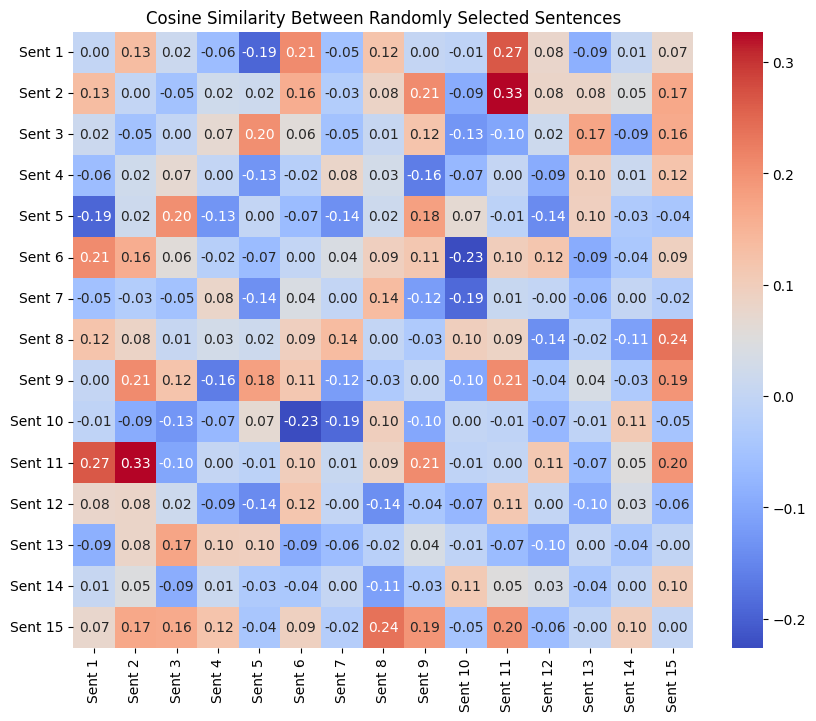

In [ ]:
# Plotting the similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=[f"Sent {i+1}" for i in range(num_sentences)], yticklabels=[f"Sent {i+1}" for i in range(num_sentences)])
plt.title('Cosine Similarity Between Randomly Selected Sentences')
plt.show()

# Bonus Task: Textual similarity

We will fine-tune BERT for both binary and multiclass classification.

In [ ]:
#df['text_cleaned'] = df['title'] + " " + df['body']
#df['text_cleaned'] = df['text_cleaned'].apply(lambda x: clean_text(x, lemmatize=True, remove_stopwords=True))

# Splitting into train and test sets
X = df['text_cleaned']
y_binary = (df['label'] == 1).astype(int) # binary setup: 1 for center, 0 for left/right
y_multiclass = df['label']

In [ ]:
X_df = pd.DataFrame(X, columns=['text_cleaned'])

# Undersampling the binary dataset
rus = RandomUnderSampler(random_state=42)
X_resampled_binary, y_resampled_binary = rus.fit_resample(X_df, y_binary)
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(X_resampled_binary['text_cleaned'], y_resampled_binary, test_size=0.2, random_state=42)

# Undersampling the multiclass dataset
X_resampled_multiclass, y_resampled_multiclass = rus.fit_resample(X_df, y_multiclass)
X_train_multiclass, X_test_multiclass, y_train_multiclass, y_test_multiclass = train_test_split(X_resampled_multiclass['text_cleaned'], y_resampled_multiclass, test_size=0.2, random_state=42)

In [ ]:
# German BERT model
model_name = 'dbmdz/bert-base-german-uncased'

# Tokenizer
tokenizer = BertTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples['text_cleaned'], padding='max_length', truncation=True)

# Converting to Hugging Face dataset
train_dataset_binary = Dataset.from_pandas(pd.DataFrame({'text_cleaned': X_train_binary, 'label': y_train_binary}))
test_dataset_binary = Dataset.from_pandas(pd.DataFrame({'text_cleaned': X_test_binary, 'label': y_test_binary}))

train_dataset_multiclass = Dataset.from_pandas(pd.DataFrame({'text_cleaned': X_train_multiclass, 'label': y_train_multiclass}))
test_dataset_multiclass = Dataset.from_pandas(pd.DataFrame({'text_cleaned': X_test_multiclass, 'label': y_test_multiclass}))

train_dataset_binary = train_dataset_binary.map(tokenize_function, batched=True)
test_dataset_binary = test_dataset_binary.map(tokenize_function, batched=True)

train_dataset_multiclass = train_dataset_multiclass.map(tokenize_function, batched=True)
test_dataset_multiclass = test_dataset_multiclass.map(tokenize_function, batched=True)

train_dataset_binary.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset_binary.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

train_dataset_multiclass.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset_multiclass.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/11022 [00:00<?, ? examples/s]

Map:   0%|          | 0/2756 [00:00<?, ? examples/s]

Map:   0%|          | 0/2923 [00:00<?, ? examples/s]

Map:   0%|          | 0/731 [00:00<?, ? examples/s]

In [ ]:
#!pip install accelerate -U

In [ ]:
#custom  class for applying early stopping regularization to stop training
#when no longer the validation loss improves over number of patience allowance
from transformers import TrainerCallback
class CustomEarlyStoppingCallback(TrainerCallback):
    def __init__(self, patience=5):
        self.patience = patience
        self.best_metric = None #stores the best (lowest) evaluation loss observed during training
        self.counter = 0

    def on_evaluate(self, args, state, control, **kwargs):
        # Get the evaluation metric
        metrics = kwargs.get('metrics', {})
        eval_loss = metrics.get('eval_loss')

        if self.best_metric is None or eval_loss < self.best_metric:
            self.best_metric = eval_loss
            self.counter = 0
        else:
            self.counter += 1

        if self.counter >= self.patience:
            control.should_training_stop = True

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def compute_metrics(p, is_multiclass=False):
    preds = p.predictions.argmax(-1) if is_multiclass else p.predictions[:, 1] > 0.5
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='binary' if not is_multiclass else 'weighted')
    acc = accuracy_score(p.label_ids, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
# Using GPU if available (trained on Colab)
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Fine-tuning BERT for binary classification
model_binary = BertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

training_args_binary = TrainingArguments(
    output_dir='./results_binary',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    fp16=True,  # Mixed precision training
    save_total_limit=2,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    load_best_model_at_end=True,
)

early_stopping = CustomEarlyStoppingCallback(patience=5)

trainer_binary = Trainer(
    model=model_binary,
    args=training_args_binary,
    train_dataset=train_dataset_binary,
    eval_dataset=test_dataset_binary,
    compute_metrics=lambda p: compute_metrics(p, is_multiclass=False),
    callbacks=[early_stopping]
)

trainer_binary.train()

# Saving the model
model_binary.save_pretrained('./model_binary')

# Evaluating binary model
results_binary = trainer_binary.evaluate()
print(f"Binary model evaluation results: {results_binary}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-german-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,0.648900,0.608976,0.567489,0.262376,0.890756,0.153846
100,0.581200,0.601069,0.658926,0.530938,0.849840,0.386067
150,0.575200,0.601223,0.712264,0.675930,0.773620,0.600145
200,0.630900,0.575646,0.506894,0.027201,1.000000,0.013788
250,0.590300,0.560770,0.619013,0.385965,0.993976,0.239478
300,0.622200,0.511334,0.755806,0.733254,0.807860,0.671263
350,0.417300,0.361501,0.740203,0.652089,0.986765,0.486938
400,0.316600,0.319916,0.816763,0.790717,0.921739,0.692308
450,0.385100,0.342758,0.866836,0.857586,0.921601,0.801887
500,0.312200,0.470494,0.855588,0.845497,0.909015,0.790276


Binary model evaluation results: {'eval_loss': 0.18549437820911407, 'eval_accuracy': 0.9132801161103048, 'eval_f1': 0.9081122645136485, 'eval_precision': 0.9656582174979559, 'eval_recall': 0.8570391872278664, 'eval_runtime': 3.4133, 'eval_samples_per_second': 807.432, 'eval_steps_per_second': 50.684, 'epoch': 2.1770682148040637}


In [ ]:
# Fine-tuning BERT for multiclass classification
model_multiclass = BertForSequenceClassification.from_pretrained(model_name, num_labels=3).to(device)

training_args_multiclass = TrainingArguments(
    output_dir='./results_multiclass',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    fp16=True,  # Mixed precision training
    save_total_limit=2,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    load_best_model_at_end=True,
)
early_stopping = CustomEarlyStoppingCallback(patience=5)

trainer_multiclass = Trainer(
    model=model_multiclass,
    args=training_args_multiclass,
    train_dataset=train_dataset_multiclass,
    eval_dataset=test_dataset_multiclass,
    compute_metrics=lambda p: compute_metrics(p, is_multiclass=True),
    callbacks=[early_stopping]
)

trainer_multiclass.train()

# Saving the model
model_multiclass.save_pretrained('./model_multiclass')

# Evaluating multiclass model
results_multiclass = trainer_multiclass.evaluate()
print(f"Multiclass model evaluation results: {results_multiclass}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-german-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.017500,0.976411,0.532148,0.515274,0.634573,0.532148
100,0.888000,0.871133,0.600547,0.593409,0.676904,0.600547
150,0.819100,0.693157,0.696306,0.692732,0.692876,0.696306
200,0.780200,0.709262,0.705882,0.708696,0.721998,0.705882
250,0.609200,0.639228,0.735978,0.735078,0.771913,0.735978
300,0.442100,0.517153,0.803010,0.801454,0.824158,0.803010
350,0.512700,0.508119,0.804378,0.798947,0.842560,0.804378
400,0.509400,0.435554,0.826265,0.822743,0.844699,0.826265
450,0.332400,0.634967,0.759234,0.750582,0.793021,0.759234
500,0.412100,0.387123,0.835841,0.835685,0.840771,0.835841


Multiclass model evaluation results: {'eval_loss': 0.3871230483055115, 'eval_accuracy': 0.8358413132694938, 'eval_f1': 0.8356854978965159, 'eval_precision': 0.8407711696670933, 'eval_recall': 0.8358413132694938, 'eval_runtime': 0.9441, 'eval_samples_per_second': 774.268, 'eval_steps_per_second': 48.723, 'epoch': 4.098360655737705}


In [ ]:
# function to extract the metrics from log history for plotting
def extract_metrics(log_history, metric_name):
    steps = [entry['step'] for entry in log_history if metric_name in entry]
    values = [entry[metric_name] for entry in log_history if metric_name in entry]
    return steps, values

# function for plotting the loss and accuracy curves
def plot_metrics_curves(trainer, metric_name, ylabel, title):
    log_history = trainer.state.log_history
    train_steps, train_values = extract_metrics(log_history, metric_name)
    eval_steps, eval_values = extract_metrics(log_history, f'eval_{metric_name}')

    plt.figure(figsize=(10, 5))
    plt.plot(train_steps, train_values, label=f'Training {ylabel}')
    plt.plot(eval_steps, eval_values, label=f'Evaluation {ylabel}')
    plt.xlabel('Steps')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='upper right')
    plt.show()


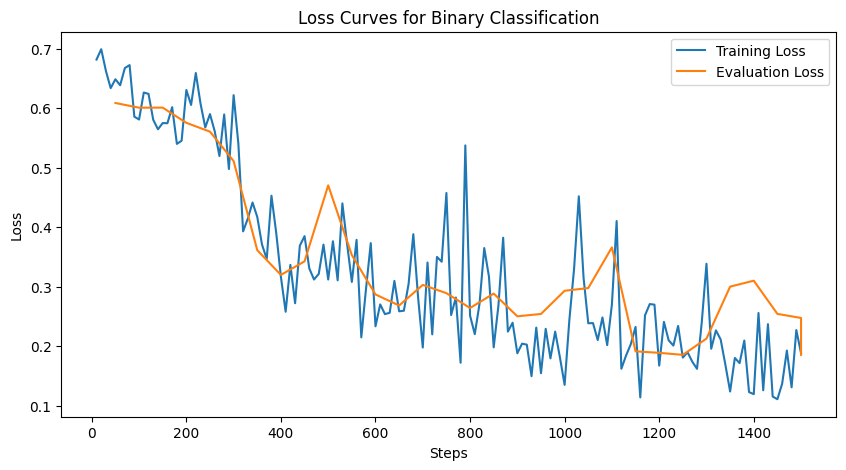

In [ ]:
# Plotting loss curves for binary classification
plot_metrics_curves(trainer_binary, 'loss', 'Loss', 'Loss Curves for Binary Classification')

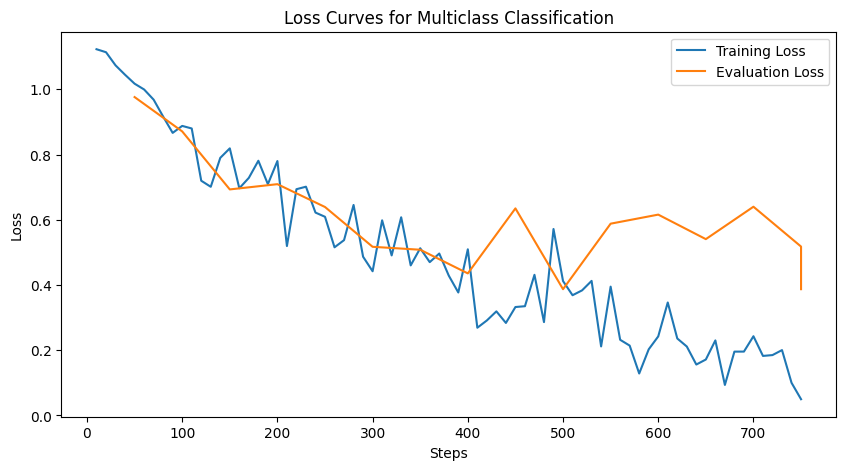

In [ ]:
# Plotting loss curves for multiclass classification
plot_metrics_curves(trainer_multiclass, 'loss', 'Loss', 'Loss Curves for Multiclass Classification')